<a href="https://colab.research.google.com/github/acse-rt1120/test/blob/main/SimpleNetworks_ipynb(week8)_separate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pycm livelossplot
%pylab inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

     |████████████████████████████████| 71kB 4.0MB/s 
     |████████████████████████████████| 573kB 26.9MB/s 
Populating the interactive namespace from numpy and matplotlib


In [3]:
import torch  # Pytorch
import torch.nn as nn  # Neural network module
import torch.nn.functional as fn  # Function module
from torchvision import datasets  # Datasets from torchvision
from torchvision import transforms  # Transforms from torchvision

import matplotlib.pyplot as plt  # Plotting using matplotlib
import numpy as np  # Numpy
from numpy import linalg
device = 'cuda'  # Set out device to GPU

print('done')  # Let me know this cell has finished

done


In [4]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


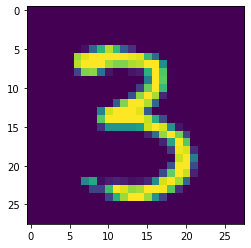

number of batches = 938
number of images = 60032


In [5]:
# MNIST Test dataset and dataloader declaration
batch_size = 64
data = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([transforms.ToTensor(),])
                   ),
                   batch_size=batch_size, shuffle=True) # Load MNIST. Use the Data Loader to shuffle and batch images

images, labels = next(iter(data)) # A trick for getting a batch out of the dataloader object
plt.imshow(images[0].squeeze()) # Show the first image from the batch
plt.show()
batch_num = len(data)
data_size = len(data)*batch_size
print('number of batches = '+str(len(data))) # Print num batches
print('number of images = '+str(len(data)*batch_size)) # Print num images

SimpleNet

Create a simple feed-forward neural network with the following architecture:
- Input Layer: 28*28 neurons
- Hidden Layer: 25 neurons
- Output Layer: 10 neurons
- Hidden Layer Activation: ReLU
- Output Layer Activation: None

In [6]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        # use nn.Linear and nn.Relu to define your layers and activations
        self.hidden_1 = nn.Linear(28*28,25)
        self.output = nn.Linear(25,10)
        self.hidden_activation = nn.ReLU()
        self.output_activation = None
    def forward(self, x):
        # code your forward pass using the layers and activations above
        z1 = self.hidden_1(x)
        a1 = self.hidden_activation(z1)
        z2 = self.output(a1)

        return z2   # return z2 (not a2, we will see this later)

train with SGD

In [56]:
seed = 42
lr = 1e-2
momentum = 0.5
n_epochs = 30

set_seed(seed)
model = SimpleNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()

In [52]:
def train(model, optimizer, criterion, data_loader):
    # set the model in training mode so the parameters(weights)to be optimised will be updated
    model.train()
    train_loss, train_accuracy = 0, 0 # initialise loss and accuracy to 0 for training
    run_in_batch = 0
    for X, y in data_loader:              # iterate over the mini-batches defined in the data loader
        X, y = X.to(device), y.to(device) # send data to the device (GPU in our case)
        # resetting optimiser info
        optimizer.zero_grad()
        # forward pass
        a2 = model(X.view(-1, 28*28))
        #print(a2, y)
        # compute loss
        loss = criterion(a2, y)
        # backpropagation to calculate the gradients
        loss.backward()
        train_loss += loss*X.size(0)  # add it up for different mini-batches and undo loss normalisation
        # get y_pred (predictions)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # compute accuracy
        # perform a step of gradient descent
        optimizer.step()
        #print('train_loss: ',train_loss,'train_accuracy: ',train_accuracy)
        # if run_in_batch == 9:
        #   print('train_loss: ',train_loss,'train_accuracy: ',train_accuracy)
        #   break
        run_in_batch += 1
    print('train_loss: ',train_loss,'train_accuracy: ',train_accuracy)
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset

In [55]:
train_loss, train_accuracy = train(model, optimizer, criterion, data)

train_loss:  tensor(55009.4531, device='cuda:0', grad_fn=<AddBackward0>) train_accuracy:  47142.0


In [ ]:
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, data)

    logs['log loss'] = train_loss.item()
    logs['accuracy'] = train_accuracy.item()

    # test_loss, test_accuracy = validate(model, criterion, test_loader)
    # logs['val_' + 'log loss'] = test_loss.item()
    # logs['val_' + 'accuracy'] = test_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

print("Avg. Loss: %1.3f" % train_loss.item(), " Avg. Accuracy: %1.3f" % train_accuracy.item())
print("")

In [25]:
print("Model's state_dict:")
layers_num = -1
layer_size = []
for param_tensor in model.state_dict():
    layers_num += 1
    layer_size.append(list(model.state_dict()[param_tensor].size()))
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
hidden_1.weight 	 torch.Size([25, 784])
hidden_1.bias 	 torch.Size([25])
output.weight 	 torch.Size([10, 25])
output.bias 	 torch.Size([10])


In [21]:
iter= 200 #iteration time for calculation of WB
epsilon = 0.05 #test for choosing
epochs = 1 #epoches number for train network

In [22]:
def get_grad_from_this_batch(total_layer_size,which_batch,which_label,which_layer):
    this_layer_part_grad = torch.zeros((total_layer_size[which_layer][0], total_layer_size[which_layer][1], batch_size)).to(device)
    sample_num = 0
    for sample, y in zip(which_batch, which_label):
        # for param in model.parameters():
        #     param.grad = None
        a2 = model(sample.view(-1, 28*28))
        #print(a2.shape,y.shape)  
        loss = criterion(a2, y)
        #print('loss is',loss)  
        loss.backward()  # Back-propagate
        # train_loss += loss*X.size(0)
        # y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        # train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        this_layer = -1
        for param in model.parameters():
            this_layer += 1
            if this_layer == which_layer:
                #print('param.grad is', param.grad)
                this_layer_part_grad[:, :, sample_num] = param.grad.detach().clone()
        sample_num += 1
    return this_layer_part_grad
def get_positive_grads(input_grad):
    abs_global_min = torch.abs(torch.min(input_grad)).item()
    input_grad = input_grad + torch.abs(torch.min(input_grad)).item()
    return input_grad, abs_global_min
def Wasserstein_barycentre_even(total_layer_size, which_layer, iter, samples_num, input_grad):
    t0 = np.linspace(0, 1, total_layer_size[which_layer][0])
    [Y0, X0] = np.meshgrid(t0, t0)
    K0 = np.exp(-(X0 - Y0) ** 2 / epsilon)
    K0 = torch.from_numpy(K0).type(torch.FloatTensor).to(device)
    t1 = np.linspace(0, 1, total_layer_size[which_layer][1])
    [Y1, X1] = np.meshgrid(t1, t1)
    K1 = np.exp(-(X1 - Y1) ** 2 / epsilon)
    K1 = torch.from_numpy(K1).type(torch.FloatTensor).to(device)
    K = lambda x: (K0 @ x) @ K1
    v = torch.ones((total_layer_size[which_layer][0], total_layer_size[which_layer][1], samples_num)).to(device)
    u = torch.ones((total_layer_size[which_layer][0], total_layer_size[which_layer][1], samples_num)).to(device)
    Err_q = torch.zeros(iter).to(device)
    lambd = torch.ones(samples_num) / samples_num
    lambd = lambd.to(device)
    for i in range(iter):

        for k in range(samples_num):
            Err_q[i] = Err_q[i] + torch.norm(u[:, :, k] * K(v[:, :, k]) - input_grad[:,:,k], p=1)
            u[:, :, k] = input_grad[:,:,k] / K(v[:, :, k])

        b = torch.zeros((total_layer_size[which_layer][0], total_layer_size[which_layer][1])).to(device)
        for k in range(samples_num):
            b = b + lambd[k] * torch.log(torch.maximum(1e-19 * torch.ones(np.shape(v[:, :, k])).to(device), v[:, :, k] * K(u[:, :, k])))
        b = torch.exp(b)

        for k in range(samples_num):
            v[:, :, k] = b / K(u[:, :, k])
    return b
def assign_back_layer(model, input_grads, which_layer, lr=0.001):
    this_layer = -1
    for param in model.parameters():
      this_layer = this_layer+1
      if this_layer == which_layer:
          #print('before ', param)
          param = param + lr * input_grads
          #print('after ', param)
    return None

In [ ]:
def train(model,data,layers_num,batch_size, epochs):
    # optimizer is WB used in SGD
    model.train()
    train_loss_ = []
    train_acc_ = []
    for epoch in range(epochs):# Run data over numerous epochs
        print('this is ',epoch,'epoch')
        train_loss, train_accuracy = 0, 0
        run_in_batch = 0
        for batch, label in data:# Iterate over the batches of images and labels
            batch, label = batch.to(device), label.to(device)
            a2 = model(batch.view(-1, 28*28))
            loss = criterion(a2, label)
            train_loss += loss*batch.size(0)
            label = torch.reshape(label,shape=(len(batch),1))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            train_accuracy += accuracy_score(label.cpu().numpy(), y_pred.detach().cpu().numpy())*len(batch)
            
            
            #分层计算(仅weights)
            for i in range(0, layers_num, 2): #两次
              this_batch_layer_grad = get_grad_from_this_batch(layer_size,batch,label,i)#本batch 的local gradients的集合
              # 放弃将weights和baise和在一起了
              this_batch_layer_grad, abs_global_min = get_positive_grads(this_batch_layer_grad)
              #print(abs_global_min)  # 将gards变成正的
              # if i == 2:#打印第2层的grads
              #   print("thisbatchlayergrad in layer",i," for sample", batch_size-1)
              #   this_batch_layer_cpu = this_batch_layer_grad.cpu().detach().numpy().copy()
              #   plt.figure(figsize=(10,10))
              #   im = plt.imshow(this_batch_layer_cpu[:,:,batch_size-1], cmap='seismic')
              #   plt.colorbar(im,fraction=0.044, pad=0.1)
              #   plt.title("$thisbatchlayergrad$")
              #   plt.axis('off');
              WB_in_this_batch = Wasserstein_barycentre_even(layer_size, i, iter, batch_size, this_batch_layer_grad)  # 得到WB
              # if i == 2:
              #   WB_in_this_batch_cpu = WB_in_this_batch.cpu().detach().numpy().copy()
              #   print("WBinthisbatch in layer",i," for", batch_size, "samples")
              #   plt.figure(figsize=(10,10))
              #   plt.imshow(WB_in_this_batch_cpu, cmap='seismic')
              #   plt.colorbar(im,fraction=0.044, pad=0.1)
              #   plt.title("$WBinthisbatch$")
              #   plt.axis('off');
            #break
              #free the memory
              this_batch_layer_grad = this_batch_layer_grad.cpu()
              torch.cuda.empty_cache()
              WB_in_this_batch = WB_in_this_batch - abs_global_min  # 将new_global_grad恢复为原来数值
              assign_back_layer(model, WB_in_this_batch, i)  # 将new_global_grad放回去更新参数
              #free the memory of this
              WB_in_this_batch = WB_in_this_batch.cpu()
              torch.cuda.empty_cache()
            #print("current run in batch ", run_in_batch)
            run_in_batch += 1
            #break
            print("acc",train_accuracy/data_size)
        train_acc_.append(train_accuracy/data_size)
        train_loss_.append(train_loss/data_size)
    return train_loss_, train_acc_

In [ ]:
a, b = train(model, data, layers_num,batch_size,epochs)

In [ ]:
print(b)

[0.09743136993603412, 0.09743136993603412]


separate into small parts to validation the calculation

In [ ]:
def Wasserstein_barycentre_even(epsilon,total_layer_size, which_layer, iter, samples_num, input_grad):
    t0 = np.linspace(0, 1, total_layer_size[which_layer][0])
    [Y0, X0] = np.meshgrid(t0, t0)
    K0 = np.exp(-(X0 - Y0) ** 2 / epsilon)
    K0 = torch.from_numpy(K0).type(torch.FloatTensor).to(device)
    t1 = np.linspace(0, 1, total_layer_size[which_layer][1])
    [Y1, X1] = np.meshgrid(t1, t1)
    K1 = np.exp(-(X1 - Y1) ** 2 / epsilon)
    K1 = torch.from_numpy(K1).type(torch.FloatTensor).to(device)
    K = lambda x: (K0 @ x) @ K1
    v = torch.ones((total_layer_size[which_layer][0], total_layer_size[which_layer][1], samples_num)).to(device)
    u = torch.ones((total_layer_size[which_layer][0], total_layer_size[which_layer][1], samples_num)).to(device)
    Err_q = torch.zeros(iter).to(device)
    lambd = torch.ones(samples_num) / samples_num
    lambd = lambd.to(device)
    for i in range(iter):

        for k in range(samples_num):
            Err_q[i] = Err_q[i] + torch.norm(u[:, :, k] * K(v[:, :, k]) - input_grad[:,:,k], p=1)
            u[:, :, k] = input_grad[:,:,k] / K(v[:, :, k])

        b = torch.zeros((total_layer_size[which_layer][0], total_layer_size[which_layer][1])).to(device)
        for k in range(samples_num):
            b = b + lambd[k] * torch.log(torch.maximum(1e-19 * torch.ones(np.shape(v[:, :, k])).to(device), v[:, :, k] * K(u[:, :, k])))
        b = torch.exp(b)

        for k in range(samples_num):
            v[:, :, k] = b / K(u[:, :, k])
    Err_q_cpu = Err_q.cpu().detach().numpy().copy()
    #plt.figure(figsize=(7,5))
    plt.plot(np.log(Err_q_cpu), label='$\epsilon=$' + str(epsilon))
    plt.legend();

    return b

In [ ]:
def get_epsilon(model,data,layers_num,batch_size, epsilon, epochs):
    # optimizer is WB used in SGD
    for epoch in range(epochs):# Run data over numerous epochs
        print('this is ',epoch,'epoch')
        train_loss, train_accuracy = 0, 0
        run_in_batch = 0
        for batch, label in data:# Iterate over the batches of images and labels
            batch, label = batch.to(device), label.to(device)
            label = torch.reshape(label,shape=(len(batch),1))
            #分层计算(仅weights)
            for i in range(0, layers_num, 2): #两次
              this_batch_layer_grad = get_grad_from_this_batch(layer_size,batch,label,i)#本batch 的local gradients的集合
              # 放弃将weights和baise和在一起了
              this_batch_layer_grad, abs_global_min = get_positive_grads(this_batch_layer_grad)
              #print(abs_global_min)  # 将gards变成正的
              # if i == 2:#打印第2层的grads
              #   print("thisbatchlayergrad in layer",i," for sample", batch_size-1)
              #   this_batch_layer_cpu = this_batch_layer_grad.cpu().detach().numpy().copy()
              #   plt.figure(figsize=(10,10))
              #   im = plt.imshow(this_batch_layer_cpu[:,:,batch_size-1], cmap='seismic')
              #   plt.colorbar(im,fraction=0.044, pad=0.1)
              #   plt.title("$thisbatchlayergrad$")
              #   plt.axis('off');
              
              WB_in_this_batch= Wasserstein_barycentre_even(epsilon,layer_size, i, iter, batch_size, this_batch_layer_grad)  # 得到WB

              # if i == 2:
              #   WB_in_this_batch_cpu = WB_in_this_batch.cpu().detach().numpy().copy()
              #   print("WBinthisbatch in layer",i," for", batch_size, "samples")
              #   plt.figure(figsize=(10,10))
              #   im = plt.imshow(WB_in_this_batch_cpu, cmap='seismic')
              #   plt.colorbar(im,fraction=0.044, pad=0.1)
              #   plt.title("$WBinthisbatch$")
              #   plt.axis('off');
            break
    return None

this is  0 epoch
this is  0 epoch
this is  0 epoch


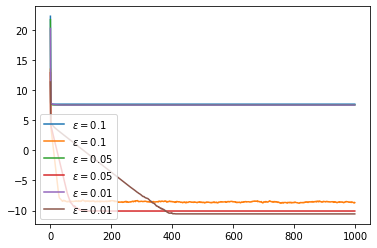

In [ ]:
for epsilon in (.1, .05, .01,):
  get_epsilon(model, data, layers_num,batch_size,epsilon,epochs)


this is  0 epoch


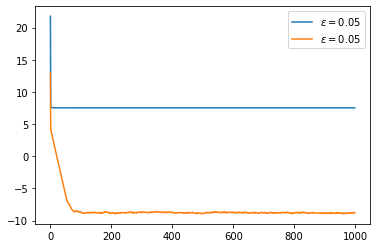

In [ ]:
get_epsilon(model, data, layers_num,batch_size,epsilon=0.05,epochs=1)

choose epsilon equals to 0.05 iter 200 times

train the network

In [57]:
def train_WB(model,data,layers_num,batch_size, epochs):
    # optimizer is WB used in SGD
    model.train()
    train_loss, train_accuracy = 0, 0
    run_in_batch = 0
    for batch, label in data:  # Iterate over the batches of images and labels
        batch, label = batch.to(device), label.to(device)
        for param in model.parameters():
          param.grad = None
        a2 = model(batch.view(-1, 28 * 28))
        loss = criterion(a2, label)
        train_loss += loss * batch.size(0)
        label = torch.reshape(label, shape=(len(batch), 1))
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(label.cpu().numpy(), y_pred.detach().cpu().numpy()) * len(batch)
        # 分层计算(仅weights)
        for i in range(0, layers_num, 2):  # 两次
            this_batch_layer_grad = get_grad_from_this_batch(layer_size, batch, label, i)  # 本batch 的local gradients的集合
            # 放弃将weights和baise和在一起了
            this_batch_layer_grad, abs_global_min = get_positive_grads(this_batch_layer_grad)
            # print(abs_global_min)  # 将gards变成正的
            # if i == 2:#打印第2层的grads
            #   print("thisbatchlayergrad in layer",i," for sample", batch_size-1)
            #   this_batch_layer_cpu = this_batch_layer_grad.cpu().detach().numpy().copy()
            #   plt.figure(figsize=(10,10))
            #   im = plt.imshow(this_batch_layer_cpu[:,:,batch_size-1], cmap='seismic')
            #   plt.colorbar(im,fraction=0.044, pad=0.1)
            #   plt.title("$thisbatchlayergrad$")
            #   plt.axis('off');
            WB_in_this_batch = Wasserstein_barycentre_even(layer_size, i, iter, batch_size,
                                                           this_batch_layer_grad)  # 得到WB
            # if i == 2:
            #   WB_in_this_batch_cpu = WB_in_this_batch.cpu().detach().numpy().copy()
            #   print("WBinthisbatch in layer",i," for", batch_size, "samples")
            #   plt.figure(figsize=(10,10))
            #   plt.imshow(WB_in_this_batch_cpu, cmap='seismic')
            #   plt.colorbar(im,fraction=0.044, pad=0.1)
            #   plt.title("$WBinthisbatch$")
            #   plt.axis('off');
            # break
            # free the memory
            # this_batch_layer_grad = this_batch_layer_grad.cpu()
            # torch.cuda.empty_cache()
            WB_in_this_batch = WB_in_this_batch - abs_global_min  # 将new_global_grad恢复为原来数值
            assign_back_layer(model, WB_in_this_batch, i)  # 将new_global_grad放回去更新参数
            # free the memory of this
            # WB_in_this_batch = WB_in_this_batch.cpu()
            # torch.cuda.empty_cache()
        # print("current run in batch ", run_in_batch)
        # print('train_loss: ',train_loss,'train_accuracy: ',train_accuracy)
        # if run_in_batch ==9:
        #   break
        run_in_batch += 1
        # break
    print('train_loss: ',train_loss,'train_accuracy: ',train_accuracy)    
  
    return train_loss_, train_acc_

In [58]:
train_loss_ = []
train_acc_ = []
train_loss_, train_acc_ = train_WB(model, data, layers_num,batch_size,epochs)
# plt.plot(train_loss_)
# plt.plot(train_acc_)

train_loss:  tensor(138597.5000, device='cuda:0', grad_fn=<AddBackward0>) train_accuracy:  5849.0


In [ ]:
train_loss_ = []
train_acc_ = []

  train_loss, train_accuracy = train(model, data, layers_num,batch_size,epochs)
  train_loss_.append(train_loss)
  train_acc_.append(train_accuracy)
plt.plot(train_loss_)
plt.plot(train_acc_)